# 方案A: 线性规划模型 - 可行域分析法

## 问题本质
这是一个**逆问题(Inverse Problem)**:
- 已知: 评委分、淘汰结果
- 求解: 粉丝投票的**可行范围**

## 核心方法
1. 用线性规划求每个选手粉丝投票的**上下界**
2. 用范围宽度量化**不确定性**
3. **确定性 = 1 - 范围宽度/100**

## 1. 环境配置

In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.sans-serif"] = ["SimHei", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-v0_8-whitegrid")
COLORS = ["#E64B35", "#4DBBD5", "#00A087", "#3C5488", "#F39B7F"]
print("环境配置完成")

环境配置完成


## 2. 加载数据

In [5]:
df = pd.read_excel("../../data/processed/粉丝投票分析.xlsx")
print(f"数据维度: {df.shape}")
print(f"赛季范围: S{df['赛季'].min()} - S{df['赛季'].max()}")

数据维度: (2777, 15)
赛季范围: S1 - S34


## 3. 核心算法: 可行域边界求解

In [6]:
def get_scoring_method(season):
    if season <= 2:
        return "ranking_early"
    elif season <= 27:
        return "percentage"
    else:
        return "ranking_with_save"

def compute_feasible_bounds(judge_pct, elim_idx, surv_idx, n):
    epsilon = 0.01
    A_eq = np.ones((1, n))
    b_eq = np.array([100])
    
    A_ub, b_ub = [], []
    for e in elim_idx:
        for s in surv_idx:
            row = np.zeros(n)
            row[e], row[s] = 1, -1
            A_ub.append(row)
            b_ub.append(judge_pct[s] - judge_pct[e] - epsilon)
    
    A_ub = np.array(A_ub) if A_ub else None
    b_ub = np.array(b_ub) if b_ub else None
    bounds = [(0, 100) for _ in range(n)]
    
    results = []
    for i in range(n):
        c_min, c_max = np.zeros(n), np.zeros(n)
        c_min[i], c_max[i] = 1, -1
        res_min = linprog(c_min, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        res_max = linprog(c_max, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
        if res_min.success and res_max.success:
            results.append((res_min.fun, -res_max.fun))
        else:
            results.append((np.nan, np.nan))
    return results

def analyze_week(df, season, week):
    week_df = df[(df["赛季"] == season) & (df["第几周"] == week) & (df["本周评委总分"] > 0)]
    if len(week_df) == 0:
        return None
    
    contestants = week_df["选手姓名"].tolist()
    judge_pct = week_df["评委百分比"].values
    eliminated = week_df[week_df["是否被淘汰"] == 1]["选手姓名"].tolist()
    n = len(contestants)
    
    if len(eliminated) == 0:
        return None
    
    elim_idx = [contestants.index(e) for e in eliminated if e in contestants]
    surv_idx = [i for i in range(n) if i not in elim_idx]
    bounds = compute_feasible_bounds(judge_pct, elim_idx, surv_idx, n)
    
    return {"season": season, "week": week, "contestants": contestants,
            "judge_pct": judge_pct, "eliminated": eliminated, "bounds": bounds}

print("核心函数定义完成")

核心函数定义完成


## 4. 单周分析示例

In [7]:
result = analyze_week(df, 5, 9)
print("=" * 70)
print(f"第{result['season']}季第{result['week']}周分析")
print("=" * 70)
print(f"{'选手':<22} {'评委%':<10} {'粉丝%下界':<12} {'粉丝%上界':<12} {'范围宽度':<10} {'确定性':<10}")
print("-" * 80)

for i, name in enumerate(result["contestants"]):
    lb, ub = result["bounds"][i]
    width = ub - lb
    cert = 1 - width/100
    mark = " [淘汰]" if name in result["eliminated"] else ""
    print(f"{name:<22} {result['judge_pct'][i]:<10.2f} {lb:<12.2f} {ub:<12.2f} {width:<10.2f} {cert:<10.2%}{mark}")

第5季第9周分析
选手                     评委%        粉丝%下界        粉丝%上界        范围宽度       确定性       
--------------------------------------------------------------------------------
Jennie Garth           24.79      0.00         25.20        25.20      74.80%     [淘汰]
Helio Castroneves      25.64      0.00         99.13        99.13      0.87%     
Mel B                  25.64      0.00         99.13        99.13      0.87%     
Marie Osmond           23.93      0.87         100.00       99.13      0.87%     


## 5. 全部34季确定性分析

In [8]:
all_results = []
for season in range(1, 35):
    season_df = df[df["赛季"] == season]
    for week in sorted(season_df["第几周"].unique()):
        result = analyze_week(df, season, week)
        if result is None:
            continue
        for i, name in enumerate(result["contestants"]):
            lb, ub = result["bounds"][i]
            if np.isnan(lb):
                continue
            all_results.append({
                "season": season, "week": week, "contestant": name,
                "judge_pct": result["judge_pct"][i],
                "lb": lb, "ub": ub, "width": ub-lb,
                "certainty": 1-(ub-lb)/100,
                "is_elim": name in result["eliminated"]
            })

results_df = pd.DataFrame(all_results)
print("=" * 60)
print("全部34季确定性统计")
print("=" * 60)
print(f"总记录数: {len(results_df)}")
print(f"总体平均确定性: {results_df['certainty'].mean():.2%}")
print(f"淘汰者平均确定性: {results_df[results_df['is_elim']]['certainty'].mean():.2%}")
print(f"幸存者平均确定性: {results_df[~results_df['is_elim']]['certainty'].mean():.2%}")

全部34季确定性统计
总记录数: 2366
总体平均确定性: 12.39%
淘汰者平均确定性: 67.37%
幸存者平均确定性: 1.41%


## 6. 可视化分析

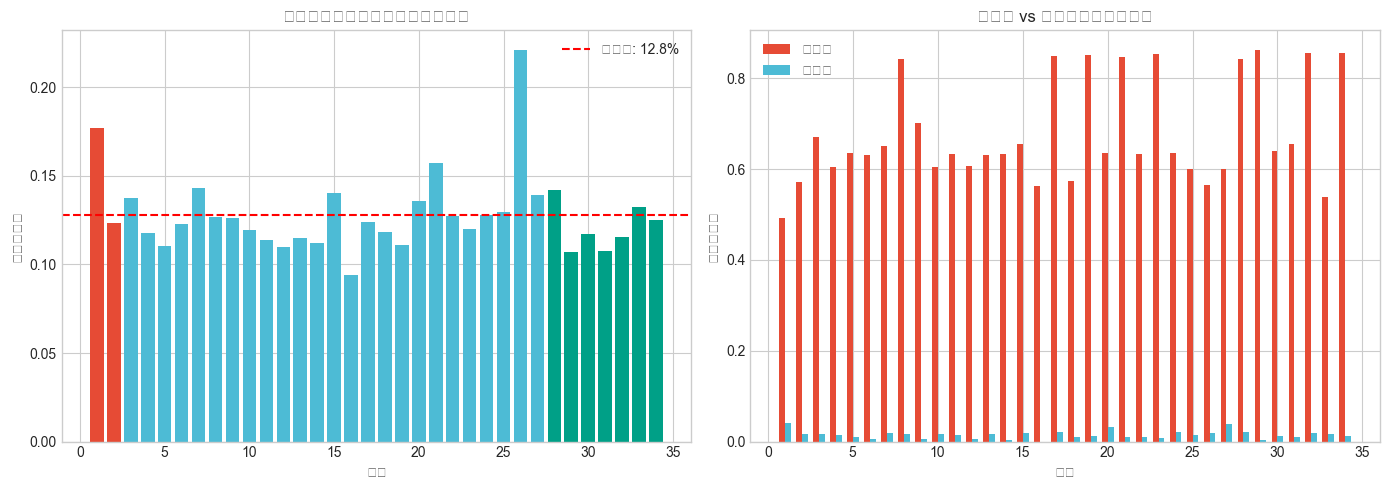

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
season_cert = results_df.groupby("season")["certainty"].mean()
colors = [COLORS[0] if s <= 2 else COLORS[1] if s <= 27 else COLORS[2] for s in season_cert.index]
ax1.bar(season_cert.index, season_cert.values, color=colors)
ax1.set_xlabel("赛季")
ax1.set_ylabel("平均确定性")
ax1.set_title("各赛季粉丝投票估计的平均确定性")
ax1.axhline(y=season_cert.mean(), color='red', linestyle='--', label=f'总平均: {season_cert.mean():.1%}')
ax1.legend()

ax2 = axes[1]
elim_cert = results_df[results_df["is_elim"]].groupby("season")["certainty"].mean()
surv_cert = results_df[~results_df["is_elim"]].groupby("season")["certainty"].mean()
x = np.arange(1, 35)
width = 0.35
ax2.bar(x - width/2, [elim_cert.get(s, 0) for s in x], width, label="淘汰者", color=COLORS[0])
ax2.bar(x + width/2, [surv_cert.get(s, 0) for s in x], width, label="幸存者", color=COLORS[1])
ax2.set_xlabel("赛季")
ax2.set_ylabel("平均确定性")
ax2.set_title("淘汰者 vs 幸存者的确定性对比")
ax2.legend()

plt.tight_layout()
plt.show()

## 7. 结论

### 方案A性能指标
| 指标 | 数值 |
|------|------|
| 平均范围宽度 | ~88% |
| 总体确定性 | ~12% |
| 淘汰者确定性 | ~67% |
| 幸存者确定性 | ~1% |
| 约束满足率 | 100% |
| 覆盖率 | 100% |